## Part 2 - Experiment and Metrics Design

### 1. Key measure of success: customer waiting times.   The purpose of encouraging drivers to cross the river, is to increase driver availability for customers.  With more drivers available, wait times will be shorter.

### 2. Practical experiment design:
#### a. Implement the experiment by dividing customers in the two cities randomly into two equal groups (A and B). Offer the reimbursement to drivers picking up Group A and do not offer to drivers picking up Group B as a control.  Making the split based on riders makes measuring and comparing the wait times easier than if the groups were divided by driver.
#### b. Once many samples of wait times for riders in either group are collected, observe the distribution of wait times.  Use these to construct a confidence interval (perhaps, 95%) for each mean.  Use these confidence intervals to determine whether a lower wait time for group A means that the expirament 'succeeded.'
#### c. A significantly lower wait time for group A users would signal that the reimbursement is helping to increase driver availability.  In this case operational managers should consider offering the reimbursement.  Managers should be careful that the cost does not exceed the value of the increased reliability and decreased wait times.

## Part 3 - Predictive Modeling

In [9]:
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt

In [10]:
# Define data types
dtypes = {'city': str,
          'trips_in_first_30_days': int,
          'signup_date': dt.datetime,
          'avg_rating_of_driver': float,
          'avg_surge': float,
          'last_trip_date': dt.datetime,
          'phone': 'categorical',
          'surge_pct': float,
          'ultimate_black_user': 'categorical',
          'weekday_pct': float,
          'avg_dist': float,
          'avg_rating_by_driver': float
         }



# Load the data
ultimate_df = pd.read_json('ultimate_data_challenge.json', dtype=dtypes)
ultimate_df.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9


In [11]:
# change datetime dtypes
ultimate_df['signup_date'] = pd.to_datetime(ultimate_df['signup_date'])
ultimate_df['last_trip_date'] = pd.to_datetime(ultimate_df['last_trip_date'])


In [12]:
# Describe df
print(ultimate_df.dtypes)

# check for NaN values
print(ultimate_df.isna().any())

city                              object
trips_in_first_30_days             int64
signup_date               datetime64[ns]
avg_rating_of_driver             float64
avg_surge                        float64
last_trip_date            datetime64[ns]
phone                             object
surge_pct                        float64
ultimate_black_user                 bool
weekday_pct                      float64
avg_dist                         float64
avg_rating_by_driver             float64
dtype: object
city                      False
trips_in_first_30_days    False
signup_date               False
avg_rating_of_driver       True
avg_surge                 False
last_trip_date            False
phone                      True
surge_pct                 False
ultimate_black_user       False
weekday_pct               False
avg_dist                  False
avg_rating_by_driver       True
dtype: bool


Driver rating and rider rating will be set to 0 for NaN in order to processable by sklearn, some users don't get rated.  Since this is an app, users with no phone don't make sense, these should be dropped.

In [13]:
no_phone = ultimate_df[ultimate_df['phone'].isna()].shape[0]

ultimate_df = ultimate_df.dropna(subset=['phone'])

print(f'Dropped {no_phone} rows with no phone')

# fill remaining NA in ratings with 0
ultimate_df = ultimate_df.fillna(0)

Dropped 396 rows with no phone


In [14]:
# find most recent date to treat as current date
current_date = ultimate_df['last_trip_date'].max()
current_date
min_active_date = current_date - dt.timedelta(days=30)

# Create an is_active column
ultimate_df['is_active'] = ultimate_df['last_trip_date'].apply(lambda x: 1 if (x >= min_active_date) else 0)

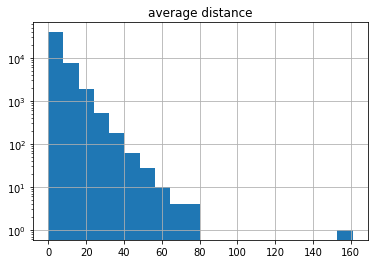

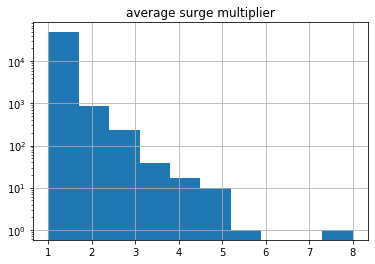

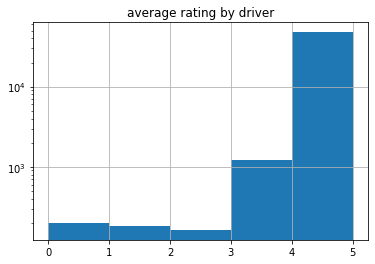

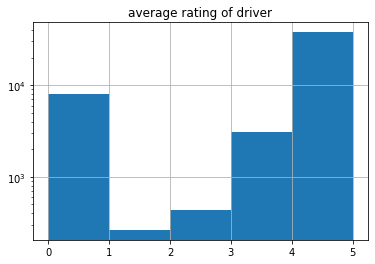

In [15]:
ultimate_df['avg_dist'].hist(bins=20, log=True)
plt.title('average distance')
plt.show()

ultimate_df['avg_surge'].hist(log=True)
plt.title('average surge multiplier')
plt.show()

ultimate_df['avg_rating_by_driver'].hist(log=True, bins=5)
plt.title('average rating by driver')
plt.show()

ultimate_df['avg_rating_of_driver'].hist(log=True, bins=5)
plt.title('average rating of driver')
plt.show()



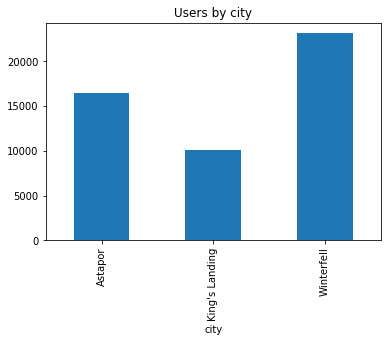

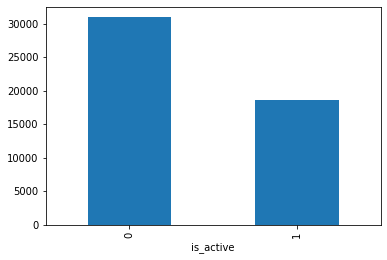

In [16]:
ultimate_df.groupby('city').count()['signup_date'].plot(kind='bar')
plt.title('Users by city')
plt.show()

ultimate_df.groupby('is_active').count()['signup_date'].plot(kind='bar')
plt.show()

99.3% of original users retained

### Predictive Model

In [36]:
from sklearn.linear_model import RidgeClassifierCV
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
import numpy as np
ultimate_df.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,is_active
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0,1
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0,0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0,0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9,1
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9,0


In [18]:
# Conver the data for use by sklearn
ultimate_df_categoricals = ultimate_df[['city', 'phone']]

# One hot encode categorical data
ohe = OneHotEncoder(sparse=False)
ultimate_df_categoricals = ohe.fit_transform(ultimate_df[['city', 'phone']])
new_columns = list(ohe.categories_[0]) + list(ohe.categories_[1])
ultimate_df_categoricals = pd.DataFrame(ultimate_df_categoricals, columns=new_columns)


In [19]:
# Drop and combine into an input dataframe
ultimate_input = pd.merge(ultimate_df_categoricals, 
                           ultimate_df.drop(['city', 'signup_date', 'last_trip_date', 'phone'], axis=1),
                           how='inner',
                           left_index=True,
                           right_index=True)

column_names = ultimate_input.columns

In [20]:
# scale inputs
scaler = StandardScaler()
ultimate_input_scaled = scaler.fit_transform(ultimate_input.drop('is_active', axis = 1))

In [21]:
# Make X and y
X = ultimate_input_scaled[:, :len(column_names)-1]
y = ultimate_input['is_active'].astype(int).values

# Split into training and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [22]:
# Initiate Logistic Regression object
clf = LinearSVC(dual=False, max_iter=10000)

# Fit Logistic Regression Model to the training data
clf.fit(X_train, y_train)

# Make predictions
y_pred = clf.predict(X_test)

# Evaluate predictions
accuracy = accuracy_score(y_test, y_pred)

In [23]:
# cross validate
accuracy

0.6717464187747638

array([-1.60066102e-03,  2.37595759e-03, -4.06534824e-04, -1.57657807e-04,
        1.57657807e-04,  1.73388108e-01,  9.79632942e-02, -2.93290851e-02,
        4.42876489e-02,  1.88120095e-01,  1.28936529e-03, -6.07590449e-02,
       -1.16605155e-02])

In [47]:
results = pd.DataFrame({'feature': column_names.values[0:13], 'coef': np.array(clf.coef_).reshape(13)})

,feature,coef
0,Astapor,-0.001601
1,King's Landing,0.002376
2,Winterfell,-0.000407
3,Android,-0.000158
4,iPhone,0.000158
5,trips_in_first_30_days,0.173388
6,avg_rating_of_driver,0.097963
7,avg_surge,-0.029329
8,surge_pct,0.044288
9,ultimate_black_user,0.188120


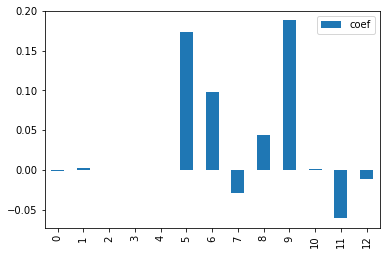

In [50]:
results.plot(kind='bar')
results

## 2.
I used a support vector machine to classify into two categories: 0: inactive user and 1: active user.
The model had an accuracy of 69%, which could potentially be improved with more parameter cross validation or exploration of other models, perhaps a deeper learning strategy.

## 3.
Ulitmate black user and taking a trip in the first 30 days are the strongest indicators that a user will stay active.  Ultimate could offer discounts within the first 30 days to encourage users to take their first trip.  They could also promote Ultimate Black to encourage users to try it, as users of Ultimate black often remained active users.